In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

%matplotlib inline

from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from numba import jit

@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', best_mcc

In [2]:
dtrain = xgb.DMatrix('dtrain.buffer')
dvalid = xgb.DMatrix('dvalid.buffer')

In [8]:
'''
df1 = pd.read_csv('../input_orig/train_numeric.csv', usecols=['Id','Response'])

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1, df1.Response.values, test_size=0.1, random_state=42, stratify=df1.Response.values)

dvalid = dtrain.slice(X_test.index)
dvalid.num_row(), X_test.shape
dtrain = dtrain.slice(X_train.index)
dtrain.num_row(), X_train.shape

#dtrain.save_binary('dtrain.buffer')
#dvalid.save_binary('dvalid.buffer')

In [4]:
y = dtrain.get_label()
prior = np.sum(y) / (1.*len(y))

In [ ]:
xgb_params1 = {
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'subsample': 0.7,
    'learning_rate': 0.3,
    'max_depth': 18,
    'min_child_weight': 3,
    'gamma': 0.3, 
    'max_delta_step': 1,
    'base_score': prior,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'silent': 0,
    'seed': 12,
    'nthread': 22
}
#'tree_method': 'exact',
evals  = [(dtrain,'train'), (dvalid,'eval')]
bst1 = xgb.train(xgb_params1, dtrain, num_boost_round=500, 
          evals=evals, early_stopping_rounds=20, 
          verbose_eval=1, feval=mcc_eval, maximize=True)

[0]	train-MCC:0.218893	eval-MCC:0.21866
Multiple eval metrics have been passed: 'eval-MCC' will be used for early stopping.

Will train until eval-MCC hasn't improved in 20 rounds.
[1]	train-MCC:0.229707	eval-MCC:0.228893
[2]	train-MCC:0.232787	eval-MCC:0.231124
[3]	train-MCC:0.235374	eval-MCC:0.234819
[4]	train-MCC:0.24111	eval-MCC:0.235924
[5]	train-MCC:0.249881	eval-MCC:0.234709
[6]	train-MCC:0.270045	eval-MCC:0.240381
[7]	train-MCC:0.308998	eval-MCC:0.247096
[8]	train-MCC:0.337688	eval-MCC:0.247189
[9]	train-MCC:0.380758	eval-MCC:0.258673
[10]	train-MCC:0.403505	eval-MCC:0.308829
[11]	train-MCC:0.437408	eval-MCC:0.347576
[12]	train-MCC:0.453834	eval-MCC:0.366061
[13]	train-MCC:0.464793	eval-MCC:0.371669
[14]	train-MCC:0.479322	eval-MCC:0.385175
[15]	train-MCC:0.489875	eval-MCC:0.392204
[16]	train-MCC:0.503415	eval-MCC:0.399443
[17]	train-MCC:0.512577	eval-MCC:0.40334
[18]	train-MCC:0.518609	eval-MCC:0.402241
[19]	train-MCC:0.5414	eval-MCC:0.400263
[20]	train-MCC:0.551987	eval-MCC:0

In [27]:
import operator
importance = bst1.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)

In [29]:
len(importance)

761

In [30]:
bst1.save_model('435461.model')

In [34]:
pred_valid = bst1.predict(dvalid, ntree_limit=bst1.best_ntree_limit)

0.435461051629 0.4354610516292058


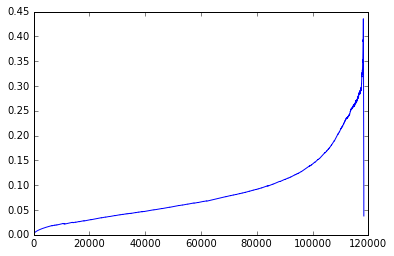

In [35]:
best_proba, best_mcc, y_pred = eval_mcc(dvalid.get_label(), pred_valid, show=True)

In [40]:
dtest = xgb.DMatrix('input_hdf/test_with_faron.buffer')

In [41]:
# generate predictions at the chosen threshold
preds = (bst1.predict(dtest, ntree_limit=bst1.best_ntree_limit) > best_proba).astype(np.int8)

In [44]:
# and submit
sub = pd.read_csv("input_orig/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("435461_submission.csv.gz", compression="gzip")